In [1]:
import numpy as np

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

In [3]:
import matplotlib.pyplot as plt

In [35]:
a = pd.DataFrame([[1, 3, 'Patrick'], 
                  [2, 3, 'Albert'],
                  [3, 4, 'Maria'],
                  [4, 4, 'Darwin'],
                  [5, 3, 'Robert'],
                  [5, 5, 'Elizabeth']], 
                 columns=['id', 'i2', 'name'])
a

,id,i2,name
0,1,3,Patrick
1,2,3,Albert
2,3,4,Maria
3,4,4,Darwin
4,5,3,Robert
5,5,5,Elizabeth


In [36]:
b = pd.DataFrame([[3, 3, 'Stars'], 
                  [1, 2, 'Climbing'],
                  [1, 3, 'Code'],
                  [6, 4, 'Rugby'],
                  [4, 5, 'Apples']], 
                 columns=['id', 'i2', 'like'])
b

,id,i2,like
0,3,3,Stars
1,1,2,Climbing
2,1,3,Code
3,6,4,Rugby
4,4,5,Apples


In [37]:
def columns(df, sel):
    c = df.columns
    return [x for x in c if x in sel] if sel else c

def stats(df, on):
    on = [on] if isinstance(on, str) else on
    
    count = df.shape[0]
    unique = df[columns(df, on)].set_index(on, drop=True).index.value_counts().count()
    ratio = unique/count
    return count, unique, ratio

In [38]:
print(stats(b, 'i2'))

(5, 4, 0.8)


In [39]:
def diff(a, b, on, sel=None):
    assert(isinstance(on, (str, list)))
    
    sel = sel or []
    on = [on] if isinstance(on, str) else on
    
    df1 = a[columns(a, on+sel)].set_index(on, drop=True)
    df2 = b[columns(b, on+sel)].set_index(on, drop=True)

    df1['v'] = True
    df2['v'] = True
    
    df_diff = df1.join(df2,how='outer',rsuffix='_').fillna(False)
    df_diff = df_diff[~df_diff['v_']].drop(['v', 'v_'], axis=1)
    return df_diff

In [41]:
diff(b,a, 'id')

""
id
6


In [42]:
def join_stats(a,b, on, sel=None, verbose=False):
    result = []
    for how in ['inner', 'left', 'right', 'outer']:
        join = a.merge(b, on=on, how=how)
        a_miss = diff(a, join, on, sel)
        b_miss = diff(b, join, on, sel)
        d = (
            how,
            *stats(join, on),
            join.isna().sum().sum(),
            *stats(a, on),
            *stats(b, on),
            a_miss.shape[0], 
            b_miss.shape[0],
        )
        
        
        if verbose:
            print('\n --- \ntesting: ', how)
            print('missing from a: ', list(a_miss.index))
            print('missing from b: ', list(b_miss.index))

            if how in ['outer', 'left']:
                print('no match any idex in a: ', list(diff(a,b, on).index))

            if how in ['outer', 'right']:
                print('no match b: ', list(diff(b,a, on).index))

            t = join[join.isna().sum(axis=1)>0]
            if t.shape[0]:
                print(t)
            else:
                print('no nulls')
            
        result.append(d)
    df = pd.DataFrame(result, columns=['type', 'count', 'unique', 'ratio', 'nulls', 'a_count', 'a_unique', 'a_ratio', 'b_count', 'b_unique', 'b_ratio', 'a_miss', 'b_miss'])
    df['idx'] = df.index
    df.set_index('type', drop=False, inplace=True)    
    return df

# favour good coverage (few nulls) vs completeness (loads of nulls)?
# missing matched indexes are less than 10%, discard that join ...
def sel_join(df):
    # right or left?
    # left
    left = 1 - (df.loc['right', 'a_miss']/df.loc['left', 'count']), df.loc['left', 'count']
    right = 1 - (df.loc['left', 'b_miss']/df.loc['right', 'count']), df.loc['right', 'count']
    outer = 1 - ((df.loc['inner', 'a_miss']+df.loc['inner', 'b_miss'])/df.loc['outer', 'count']), df.loc['outer', 'count']
    d = {'left':left, 'right':right, 'outer':outer}
    return d

In [43]:
join_stats(a,b, ['id'])

,type,count,unique,ratio,nulls,a_count,a_unique,a_ratio,b_count,b_unique,b_ratio,a_miss,b_miss,idx
type,,,,,,,,,,,,,,
inner,inner,4,3,0.750000,0,6,5,0.833333,5,4,0.8,3,1,0
left,left,7,5,0.714286,6,6,5,0.833333,5,4,0.8,0,1,1
right,right,5,4,0.800000,2,6,5,0.833333,5,4,0.8,3,0,2
outer,outer,8,6,0.750000,8,6,5,0.833333,5,4,0.8,0,0,3


In [44]:
join_stats(a,b, ['id'])

,type,count,unique,ratio,nulls,a_count,a_unique,a_ratio,b_count,b_unique,b_ratio,a_miss,b_miss,idx
type,,,,,,,,,,,,,,
inner,inner,4,3,0.750000,0,6,5,0.833333,5,4,0.8,3,1,0
left,left,7,5,0.714286,6,6,5,0.833333,5,4,0.8,0,1,1
right,right,5,4,0.800000,2,6,5,0.833333,5,4,0.8,3,0,2
outer,outer,8,6,0.750000,8,6,5,0.833333,5,4,0.8,0,0,3


In [45]:
sel_join(join_stats(a,b, ['id']))


{'left': (0.5714285714285714, 7), 'right': (0.8, 5), 'outer': (0.5, 8)}

In [46]:
import datafaucet as dfc

dfc.project.load()

Gateway is not connected.
WARNING - stop - Could not fully stop the engine context - {}
Init engine "spark"
Loading detected packages:
  -  org.apache.hadoop:hadoop-aws:3.1.1
  -  com.microsoft.sqlserver:mssql-jdbc:6.4.0.jre8
  -  mysql:mysql-connector-java:8.0.12
  -  org.postgresql:postgresql:42.2.5
Connecting to spark master: local[*]
Engine context spark:2.4.1 successfully started


In [47]:
engine = dfc.project.engine()

In [48]:
d  = engine.list('sakila').filter('type == "BASE TABLE"').select('name').collect()
names = [x.name for x in d]
names

['actor',
 'address',
 'category',
 'city',
 'country',
 'customer',
 'film',
 'film_actor',
 'film_category',
 'film_text',
 'inventory',
 'language',
 'payment',
 'rental',
 'staff',
 'store']

In [49]:
filter_cols = {
    'last_update', 
    'email', 
    'first_name', 
    'last_name', 
    'return_date',
    'picture',
    'password'
}

In [50]:
df = {}
tables = []
for name in names:
    cols = []
    d = engine.load(name, 'sakila').toPandas()
    #d.drop(columns(d, filter_cols), axis=1, inplace=True)

    df[name] = d 
    tables.append((name, dict(zip(list(d.columns), list(d.dtypes))), *d.shape))

tf = pd.DataFrame(tables, columns=['name', 'cols', 'nrows', 'ncols'])
tf.set_index('name', drop=True, inplace=True,verify_integrity=True)

In [51]:
engine.stop()

In [52]:
tf

,cols,nrows,ncols
name,,,
actor,"{'actor_id': int32, 'first_name': object, 'last_name': object, 'last_update': datetime64[ns]}",200,4
address,"{'address_id': int32, 'address': object, 'address2': object, 'district': object, 'city_id': int32, 'postal_code': object, 'phone': object, 'location': object, 'last_update': datetime64[ns]}",603,9
category,"{'category_id': int32, 'name': object, 'last_update': datetime64[ns]}",16,3
city,"{'city_id': int32, 'city': object, 'country_id': int32, 'last_update': datetime64[ns]}",600,4
country,"{'country_id': int32, 'country': object, 'last_update': datetime64[ns]}",109,3
customer,"{'customer_id': int32, 'store_id': int32, 'first_name': object, 'last_name': object, 'email': object, 'address_id': int32, 'active': bool, 'create_date': datetime64[ns], 'last_update': datetime64[ns]}",599,9
film,"{'film_id': int32, 'title': object, 'description': object, 'release_year': object, 'language_id': int32, 'original_language_id': object, 'rental_duration': int32, 'rental_rate': object, 'length': int32, 'replacement_cost': object, 'rating': object, 'special_features': object, 'last_update': datetime64[ns]}",1000,13
film_actor,"{'actor_id': int32, 'film_id': int32, 'last_update': datetime64[ns]}",5462,3
film_category,"{'film_id': int32, 'category_id': int32, 'last_update': datetime64[ns]}",1000,3


In [55]:
import itertools

edges = []
all_cols = set()
for x, y in itertools.combinations(tf.index, 2):
    common = set(tf.loc[x]['cols'].keys()) & set(tf.loc[y]['cols'].keys())
    all_cols = all_cols | common

    # check (coerced) types and filter by type
    cols = []
    for c in common:
        t = tf.loc[x]['cols'][c]
        if ( pd.api.types.is_numeric_dtype(t) or 
             pd.api.types.is_object_dtype(t)  ):
            cols.append(c)
    if cols:
        w = [round(max(stats(df[x],on)[2], stats(df[y],on)[2]), 2) for on in cols]
        cols = [cols[i] for i in range(len(cols)) if w[i]>0.9]
        w = list(filter(lambda x: x>0.9, w))
        cols = dict(zip(cols, w))
        cols = dict(sorted(cols.items(), key=lambda x: x[1], reverse=True))
        if cols:
            edges.append((x, y, cols, len(cols)))

all_cols = list(all_cols)        
ef = pd.DataFrame(edges, columns=['a', 'b', 'on', 'joins'])
ef

,a,b,on,joins
0,actor,customer,"{'last_name': 1.0, 'first_name': 0.99}",2
1,actor,film_actor,{'actor_id': 1.0},1
2,actor,staff,"{'last_name': 1.0, 'first_name': 1.0}",2
3,address,city,{'city_id': 1.0},1
4,address,customer,{'address_id': 1.0},1
5,address,staff,{'address_id': 1.0},1
6,address,store,{'address_id': 1.0},1
7,category,film_category,{'category_id': 1.0},1
8,category,language,{'name': 1.0},1
9,city,country,{'country_id': 1.0},1


In [56]:
all_cols

['name',
 'first_name',
 'title',
 'customer_id',
 'last_update',
 'description',
 'inventory_id',
 'category_id',
 'city_id',
 'rental_id',
 'email',
 'last_name',
 'store_id',
 'language_id',
 'actor_id',
 'film_id',
 'staff_id',
 'active',
 'address_id',
 'country_id']

In [57]:
import networkx as nx
plt.rcParams["figure.figsize"] = (10,10)

G=nx.MultiGraph()
G.add_nodes_from(tf.index)

for i in ef.index:
    for k,w in ef.iloc[i]['on'].items():
        G.add_edge(ef.iloc[i]['a'], ef.iloc[i]['b'], key=k, weight=w) 

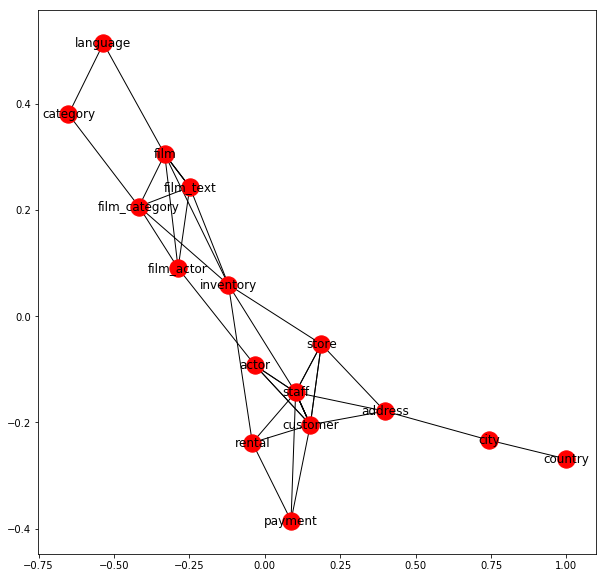

In [58]:
pos  = nx.drawing.layout.spring_layout(G, random_state=0)
nodes = nx.draw_networkx(G,pos, with_labels=True)

In [64]:
node = 'staff'

for v in nx.neighbors(G,node):
    e1 = ef[ (ef['a'] == v) & (ef['b'] == node) ]
    e2 = ef[ (ef['b'] == v) & (ef['a'] == node) ]
    d = pd.concat([e1,e2]).iloc[0]
    on = list(d['on'].keys())
    print()
    print('------ ', "join_stats(df['" + d['a']+"'], df['"+d['b']+"'],", f"{on})")
    s = join_stats(df[d['a']],df[d['b']],on, all_cols)
    print(sel_join(s))


------  join_stats(df['actor'], df['staff'], ['last_name', 'first_name'])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


{'left': (0.0, 200), 'right': (0.0, 2), 'outer': (0.0, 202)}

------  join_stats(df['address'], df['staff'], ['address_id'])
{'left': (0.0033167495854062867, 603), 'right': (1.0, 2), 'outer': (0.0033167495854062867, 603)}

------  join_stats(df['customer'], df['staff'], ['first_name', 'email', 'last_name', 'store_id', 'address_id'])
{'left': (0.0, 599), 'right': (0.0, 2), 'outer': (0.0, 601)}

------  join_stats(df['inventory'], df['staff'], ['store_id'])


MemoryError: 

In [ ]:
join_stats(df['payment'], df['staff'], ['staff_id'], ['staff_id', 'rental_id'])

In [513]:
d = df['payment']
d.isna().sum()

payment_id      0
customer_id     0
staff_id        0
rental_id       5
amount          0
payment_date    0
dtype: int64